# Counting the Cars in Images

## Approach

### The Required Output

To create the dashboard format needed to display the results of this exercise, the following dataset needs to be created by counting the number of cars for each carpark photo.

| Store Details | Time Details | Car Numbers |

### The Data

### The Model

We import the trained tensorflow model which we settled on, after training and evaluation. As this model reads images of size 256x256 we must first adjust the size of imported images before they are fed into the model.


In [2]:
#Importing packages:

#directory exploration
import os
import glob

#image processing and plotting
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

#machine learning
import tensorflow as tf

#data handling
import pandas as pd
import numpy as np

#math
from math import sqrt


## Function to Cut up Imagery

We define a function to cut up the image into pieces

In [7]:
# We need to split an image up into 256x256 pixel items
# This function is passed an integer representing where
# it is up to along with an image

# This functon is to be 

def split_up_image(output_size, whole_image):
    """
    Output size: (int) the required height and width of the image
    while_image: (np array) the image to be cut up as an array,
                 for instance as read by cv2.imread
                 
    Returns:     list of cut up images of the required size, pieces
                 of the image less than the required size have black 
                 added to them
    """
    #we set a list to handle the cut up pieces of the image
    cut_images = []
    #we will scan across the image left to right then down
    #Setting the y counter to 0
    y=0
    #get the maximum height and width of the image
    y_max, x_max = whole_image.shape[0], whole_image.shape[1]
    while (y_max-y)>=output_size:
        #if there is the full pixels needed 
        #we initiate the counter in the x direction
        x=0
        while (x_max-x)>=output_size:
            #add the cut piece of the image to the list
            cut_images.append(whole_image[y:y+output_size, x:x+output_size])
            x+=output_size
        else:
            #cut the crop image
            crop_img=whole_image[y:y+output_size, x:x_max]
            #create the border around the remaining part
            bordered_im = cv2.copyMakeBorder(crop_img, output_size-crop_img.shape[0],\
                                             0,output_size-crop_img.shape[1], 0,cv2.BORDER_CONSTANT)
            cut_images.append(bordered_im)
            x+=output_size
        y+=output_size
    else:
        #if we need to take a slice less than the 500 
        #pixels in the y direction and add padding
        #we initiate the counter in the x direction
        x=0
        while (x_max-x)>=output_size:
            #cut the crop image
            crop_img=whole_image[y:y_max, x:x+output_size]
            #create the border around the remaining part
            bordered_im = cv2.copyMakeBorder(crop_img,output_size-crop_img.shape[0],\
                                             0,output_size-crop_img.shape[1], 0,cv2.BORDER_CONSTANT)
            cut_images.append(bordered_im)
            x+=output_size
        else:
            #cut the crop image
            crop_img=whole_image[y:y_max, x:x_max]
            #create the border around the remaining part
            bordered_im = cv2.copyMakeBorder(crop_img,output_size-crop_img.shape[0],\
                                             0,output_size-crop_img.shape[1], 0,cv2.BORDER_CONSTANT)
            x+=output_size
        y+=output_size
    return cut_images

### Testing the image splitting function

We then perform a test of the image splitting function, usng the first row of our est_imagery directory, which sits in the same folder as this notebook.

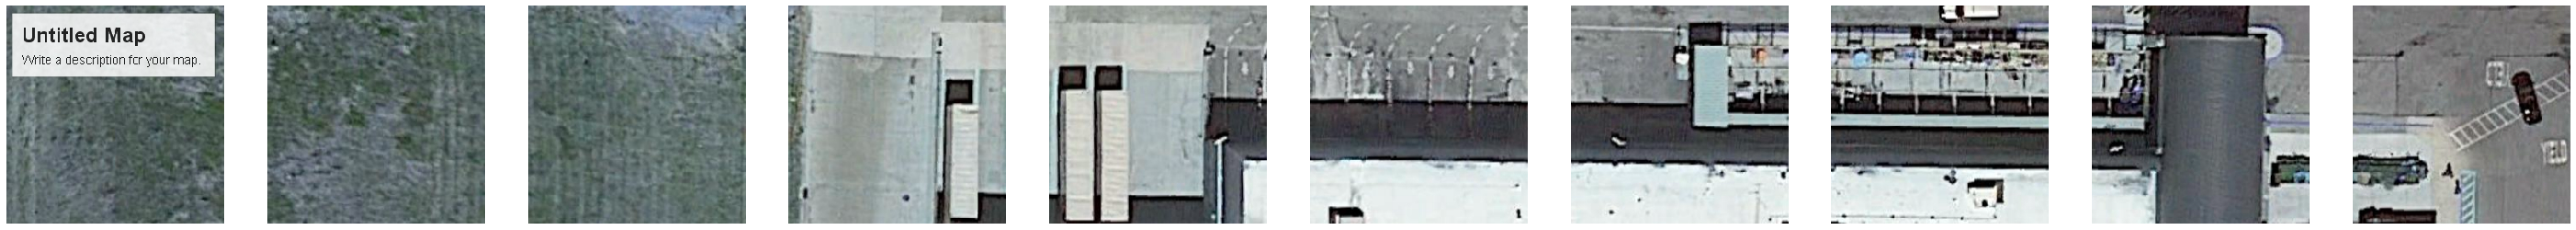

In [8]:
#We test the Function on our test imagery directory "test_imagery"
test_image = r"C:\Users\paperspace\Documents\05 Inference (Car Counting)\test_imagery\0000_StoreName\0840_04_2016.jpg"

#read the image
imported_img = cv2.imread(test_image)

#split the image
split_images = split_up_image(256, imported_img)

# display the first row to show that it has been cut up properly

fig,axes = plt.subplots(nrows = 1, ncols = 10, figsize=(50,50))

for ax in axes.flatten():
    ax.axis('off')

##label as numbers for each image
image_id_list=[range(len(split_images))]

for i,image in enumerate(split_images[0:10]):
    axes[i].imshow(image)

plt.show()


## Creating functions to import a trained model and count the images

### Importing the Model

In [5]:
PATH_TO_SAVED_MODEL = r"C:\Users\paperspace\Documents\04 Training Model\Evaluating Models\my_ssd_resnet50_v1_fpn\saved_model"
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print("model imported")

model imported


### Creating a function to run the detection model on a list of images

In [15]:
def detect_cars(input_images, model, conf_level):
    #establish variable for no of cars
    no_cars = 0
    
    for image in input_images:
        np_im=np.array(image)
        input_tensor = tf.convert_to_tensor(np_im)
        # The model expects a batch of images, so add an axis with `tf.newaxis`.
        input_tensor = input_tensor[tf.newaxis, ...]
        
        #run the detection
        detections = detect_fn(input_tensor)
        
        #collect scores
        scores = np.array(detections['detection_scores'][0])
        
        #count number of hits based on detection level
        hits = sum([score>=conf_level for score in scores])

        no_cars+=hits
    return no_cars

In [16]:
detect_cars(split_images, detect_fn, .3)

593

## Creating a function to loop through our master list of stores

### Pulling in the store list to get the relevant information

In [32]:
#import the excel at the correct sheet
excel_dir = r"C:\Users\paperspace\Documents\Stores_CompleteMaster.xlsx"
list_of_stores = pd.read_excel(excel_dir, "stores_complete")

#set the id as our id


In [33]:
relevant_store_information = list_of_stores[['mID', 'Store_Name', 'Address', 'City_State']]

### Looping through folders in our store photo directory

We now proceed to loop through each of the photos and produce a sheet with counts. The results will be stored in teh folder which we will use to create a dashboard.

In [ ]:
#set store directory
#output data address
output_directory = r"C:\Users\paperspace\Documents\06 Dashboard Preparation\output_data_.csv"

#location of photo data
store_directory = r"C:\Users\paperspace\Documents\02 Imagery Collection"
os.chdir(store_directory)
# get a list of folders
store_list = glob.glob("*")

#we initialise a list that will become our dataset, we will save this progressively
output_data = []

# loop through this list and parse the folder name
for store_folder in store_list:
    #split by the underscore
    store_id, store_name = store_folder.split("_")
    
    #print the store name
    print(store_name)
    
    #removing preceeding 0s
    store_id=int(store_id)
    
    #testing all stores can be found
    #if store_id not in relevant_store_information['mID']:
    #    print(store_id)
    
    #get a list of images in the file
    store_photos = os.listdir(os.path.join(store_directory, store_folder))
    
    #we loop through the photos
    for photo in store_photos:
        # we split the name to get the information
        photo_info = photo[:-4].split("_")
        month = photo_info[1]
        year = photo_info[2]
        #read the image
        img_cache = cv2.imread(os.path.join(store_directory, store_folder, photo))
        
        #split the image
        split_image_cache = split_up_image(256, img_cache)
        
        #count the cars
        no_cars_cache = detect_cars(split_image_cache, detect_fn, 0.3)
        
        #add to the list
        output_data.append([store_id, store_name, month, year, no_cars_cache])
    pd.DataFrame(output_data).to_csv(store_directory)
    
        